In [19]:
from __future__ import annotations

import numpy as np

import matplotlib.pyplot as plt


from math import floor 

In [228]:
class GeneticAlgorithm:
    
    def __init__(self, 
                 population_size: int, 
                 size_selection: int,
                 p_mutation_ind: float,
                 p_mutation_gen: float,
                 complexity_task: np.ndarray, 
                 time_task: np.ndarray, 
                 developer_factors: np.ndarray) -> None:
        
        self.rng = np.random.default_rng()
        self.size_selection = size_selection
        self.population_size = population_size
        self.p_mutation_ind = p_mutation_ind
        self.p_mutation_gen = p_mutation_gen
        self.num_tasks = complexity_task.shape[0]
        self.complexity_task = complexity_task
        self.time_task = time_task
        self.developer_factors = developer_factors
        self.population = np.array([self.rng.choice(list(range(1, self.developer_factors.shape[0] + 1)), self.num_tasks) for _ in range(self.population_size)])
        self.cur_score = 0.0
        self.prev_score = 0.0


    def score(self) -> float:
        return self.cur_score


    def fitness(self) -> np.ndarray:
        pop_devs = np.zeros((self.population.shape[0], self.developer_factors.shape[0]))

        for idx, entity in enumerate(self.population):
            a = self.developer_factors[entity - 1, self.complexity_task - 1] * self.time_task
            for taskIdx in range(self.num_tasks):
                pop_devs[idx, entity[taskIdx] - 1] += a[taskIdx]
        
        result = np.max(pop_devs, axis=1)

        self.prev_score = self.cur_score
        self.cur_score = 1e2 / np.min(result)

        return result


    def selection(self) -> np.ndarray:
        return self.population[np.argsort(self.fitness())[:self.size_selection]]


    def crossover(self, selected: np.ndarray) -> np.ndarray:
        new_count = self.population_size - self.size_selection
        parent_1 = self.rng.integers(0, self.size_selection, size=new_count)
        parent_2 = (self.rng.integers(1, self.size_selection, size=new_count) + parent_1) % self.size_selection

        point_1 = self.rng.integers(1, self.num_tasks - int(self.num_tasks * 0.1), size=new_count)
        point_2 = self.rng.integers(point_1, self.num_tasks - 1, size=new_count)

        mask = np.arange(self.num_tasks * new_count).reshape((new_count, self.num_tasks)) % self.num_tasks
        mask = np.apply_along_axis(lambda x: np.logical_and(point_1 <= x, x <= point_2), axis=0, arr=mask)

        return np.where(
            mask,
            selected[parent_1],
            selected[parent_2]
        )


    def mutation_inplace(self, childs: np.ndarray) -> None:
        if abs(self.cur_score - self.prev_score) <= 0.001:
            self.p_mutation_gen = max(0.05, self.p_mutation_gen - 0.005)
            #self.p_mutation_ind = max(0.1, self.p_mutation_ind - 0.001)
        
        mut_childs_mask = self.rng.choice(2, p=(1 - self.p_mutation_ind, self.p_mutation_ind), size=len(childs)) > 0
        mut_childs = self.rng.integers(1, self.developer_factors.shape[0] + 1, size=(mut_childs_mask.sum(), self.num_tasks))
        gen_childs_mask = self.rng.random(size=mut_childs.shape) <= self.p_mutation_gen
        childs[mut_childs_mask] = np.where(gen_childs_mask, mut_childs, childs[mut_childs_mask])


    def step(self) -> None:
        selected = self.selection()
        childs = self.crossover(selected)
        self.mutation_inplace(childs)
        self.population = np.concatenate([selected, childs], axis=0)

In [83]:
n = int(input())
complexity_task = np.array([int(i) for i in input().split()])
time_task = np.array([float(i) for i in input().split()])

m = int(input())
developer_factors = np.array([np.array([float(j) for j in input().split()]) for _ in range(m)])

In [229]:
population_size = 1300

ga = GeneticAlgorithm(population_size, population_size // 4, 0.5, 0.8, complexity_task, time_task, developer_factors)

In [230]:
i = 0
sc = 0
fit = 0

fitness = []
score = []
time = []

while sc < 0.170:
    i += 1
    
    fit = np.min(ga.fitness())
    sc = ga.score()
    
    time.append(i)    
    fitness.append(fit)
    score.append(sc)
    
    print(f"Best Fitness: {fit}; Score: {sc}; Prob mutation: {round(ga.p_mutation_gen, 2)} Iteration: {i}")
    ga.step()

Best Fitness: 672.0450000000002; Score: 0.14879955955330368; Prob mutation: 0.8 Iteration: 1
Best Fitness: 669.6250000000001; Score: 0.14933731566175096; Prob mutation: 0.8 Iteration: 2
Best Fitness: 669.6250000000001; Score: 0.14933731566175096; Prob mutation: 0.79 Iteration: 3
Best Fitness: 669.6250000000001; Score: 0.14933731566175096; Prob mutation: 0.79 Iteration: 4
Best Fitness: 654.0250000000001; Score: 0.15289935400022933; Prob mutation: 0.78 Iteration: 5
Best Fitness: 648.8449999999997; Score: 0.1541200132543212; Prob mutation: 0.78 Iteration: 6
Best Fitness: 645.1349999999999; Score: 0.1550063165073977; Prob mutation: 0.77 Iteration: 7
Best Fitness: 634.6549999999999; Score: 0.15756592164246722; Prob mutation: 0.77 Iteration: 8
Best Fitness: 626.7700000000002; Score: 0.15954815961197882; Prob mutation: 0.76 Iteration: 9
Best Fitness: 626.7700000000002; Score: 0.15954815961197882; Prob mutation: 0.76 Iteration: 10
Best Fitness: 626.7700000000002; Score: 0.15954815961197882; Pr

KeyboardInterrupt: 

In [ ]:
for i in ga.population[np.argmin(ga.fitness())]:
    print(i, end=' ')

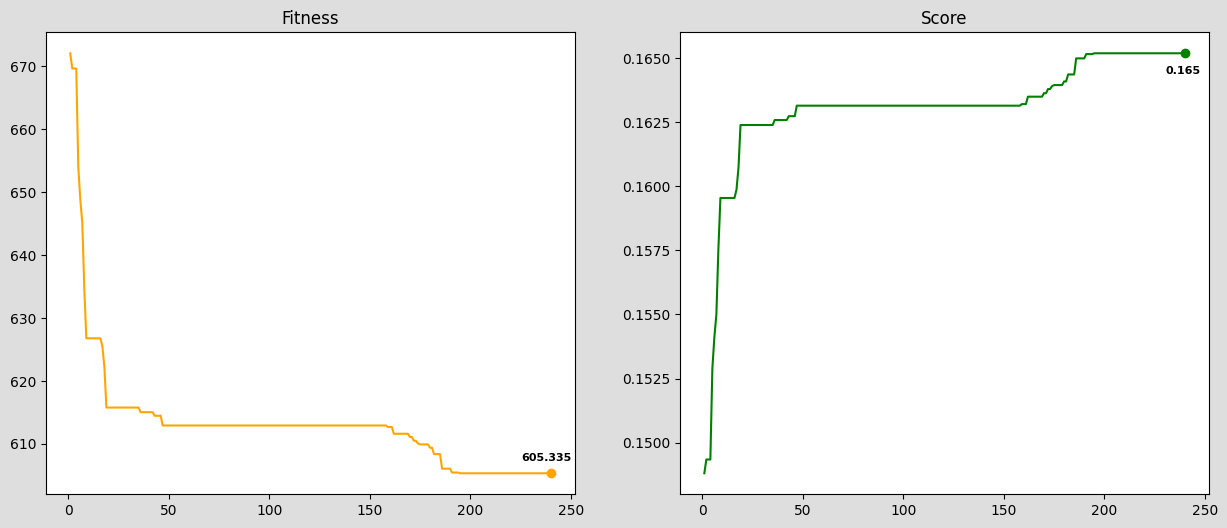

In [231]:
fig = plt.figure(figsize=(15,6), facecolor='#DEDEDE')
ax = plt.subplot(121)
ax1 = plt.subplot(122)

ax.plot(time, fitness, 'orange')
ax.scatter(time[-1], fitness[-1], c='orange')
ax.text(time[-1] - len(time) * 0.06, fitness[-1] + 2, floor(fitness[-1] * 1000) / 1000, fontsize=8, weight='bold')
ax.set_title('Fitness')

ax1.plot(time, score, 'green')
ax1.scatter(time[-1], score[-1], c='green')
ax1.text(time[-1] - len(time) * 0.04, score[-1] - 0.0008, floor(score[-1] * 1000) / 1000, fontsize=8, weight='bold')
ax1.set_title('Score')

plt.show()